In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

import umap

import warnings
warnings.filterwarnings('ignore')

In [ ]:
column_names = []
with open('/content/drive/MyDrive/JPMC Assessment/data/census-bureau.columns', 'r') as f:
    for line in f:
        column_names.append(line.strip().replace(" ","_"))

df = pd.read_csv("/content/drive/MyDrive/JPMC Assessment/data/census-bureau.data", delimiter=",")
df.columns = column_names

In [ ]:
df = df.copy()
rename_dict = {
    "fill_inc_questionnaire_for_veteran's_admin": "fill_inc_questionnaire_for_veterans_admin",
    'migration_code-change_in_msa': 'migration_code_change_in_msa',
    'migration_code-change_in_reg': 'migration_code_change_in_reg',
    'migration_code-move_within_reg': 'migration_code_move_within_reg'
}
df['hispanic_origin'] = df['hispanic_origin'].fillna('Do not know')
df.rename(columns=rename_dict, inplace=True)
df['label'] = df['label'].map({'- 50000.':0, '50000+.':1})  # Map values to 1 & 0
df['net_gains'] = (df['capital_gains'] + df['dividends_from_stocks'] - df['capital_losses'])

In [ ]:
# based on the EDA in another file, dropping a few columns which do not add up significantly in model predictions.
cols_to_drop = ['label', 'weight', 'capital_gains', 'dividends_from_stocks', 'capital_losses', 'fill_inc_questionnaire_for_veterans_admin', 'veterans_benefits', 'year',
                'enroll_in_edu_inst_last_wk', 'citizenship', 'country_of_birth_self', 'region_of_previous_residence', 'state_of_previous_residence']

X = df.drop(columns=cols_to_drop)

In [ ]:
# Get the Numeric and Categorical Features Separately
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Transform the Features to Impute Missing values, with methods like (median, most_frequent, mean, etc) but this has already been taken care while preprocessing
# Scale the numeric values, Encode the categorical values
numeric_transformer = Pipeline(
    steps=[
        #('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# Convert all the categorical features using OneHotEncoding for a few models and OrdinalEncoding for another for standardized conversion
ohe_categorical_transformer = Pipeline(
    steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]
)

# Preprocess with the above Transformations for Linear models
lr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', ohe_categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [ ]:
# Fit and Transform the data using the Preprocessor
X_scaled_sparse = lr_preprocessor.fit_transform(X)
X_scaled_dense = X_scaled_sparse.toarray()

In [ ]:
# Initialize UMAP with 2 components for visualization
umap_reducer = umap.UMAP(n_components=2, random_state=7, n_jobs=-1, verbose=True)
X_umap = umap_reducer.fit_transform(X_scaled_dense)

print(f"Data dimensions after UMAP reduction: {X_umap.shape}")

UMAP(n_jobs=1, random_state=7, verbose=True)
Sat Dec 13 17:38:41 2025 Construct fuzzy simplicial set
Sat Dec 13 17:38:41 2025 Finding Nearest Neighbors
Sat Dec 13 17:38:41 2025 Building RP forest with 27 trees
Sat Dec 13 17:38:56 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	Stopping threshold met -- exiting after 4 iterations
Sat Dec 13 17:39:21 2025 Finished Nearest Neighbor Search
Sat Dec 13 17:39:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Dec 13 17:48:58 2025 Finished embedding
Data dimensions after UMAP reduction: (199522, 2)


In [ ]:
EPS = 0.5
MIN_SAMPLES = 50

dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X_umap)

# Update the main DataFrame with new labels
df['segment_dbscan'] = dbscan_labels

# Check results
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results:")
print(f"Found {n_clusters_dbscan} clusters.")
print(f"Identified {n_noise} noise points (Label -1).")
print("Segment distribution:\n", df['segment_dbscan'].value_counts())


DBSCAN Results:
Found 248 clusters.
Identified 7630 noise points (Label -1).
Segment distribution:
 segment_dbscan
6      27895
5      24249
1      19405
12     13479
14     10488
       ...  
210       50
225       50
197       50
226       50
247       29
Name: count, Length: 249, dtype: int64


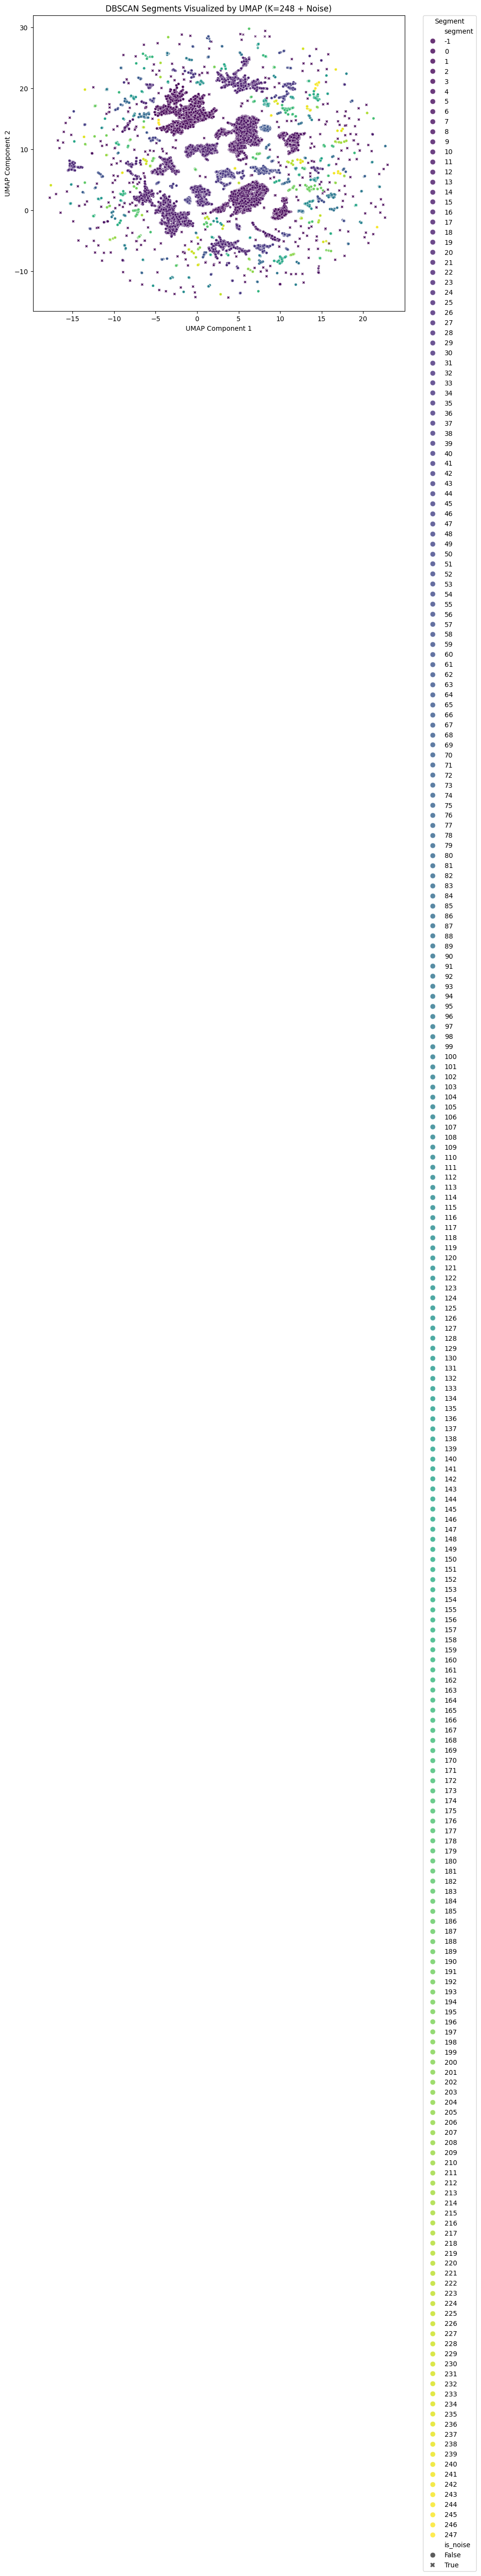

In [ ]:

plot_df = pd.DataFrame(X_umap, columns=['UMAP_1', 'UMAP_2'])
plot_df['segment'] = dbscan_labels
plot_df['is_noise'] = plot_df['segment'] == -1

plt.figure(figsize=(10, 8))

# Use Seaborn to plot the clusters
sns.scatterplot(
    x='UMAP_1',
    y='UMAP_2',
    hue='segment',
    style='is_noise',
    data=plot_df,
    palette='viridis',
    legend='full',
    s=15, # Point size
    alpha=0.8
)

plt.title(f'DBSCAN Segments Visualized by UMAP (K={n_clusters_dbscan} + Noise)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Segment', loc='best')

plt.legend(title='Segment',
           loc='upper left',
           bbox_to_anchor=(1.05, 1),
           borderaxespad=0.,
           markerscale=2)

plt.tight_layout() #
plt.show()